In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from src.anomaly_detection.autoencoder import Autoencoder

# Load dataset
df = pd.read_csv("../data/raw/UNSW_NB15_training-set.csv")
df = df.dropna()
df['label'] = df['attack_cat'].apply(lambda x: 0 if x == 'Normal' else 1)
df = df.drop(columns=['attack_cat'])
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Convert to tensor
data_tensor = torch.tensor(numeric_df.values, dtype=torch.float32)

# Create DataLoader
dataset = TensorDataset(data_tensor)
loader = DataLoader(dataset, batch_size=256, shuffle=True)

# Create model
input_dim = numeric_df.shape[1]
model = Autoencoder(input_dim=input_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(20):
    epoch_loss = 0

    for batch in loader:
        x = batch[0]

        reconstructed = model(x)
        loss = criterion(reconstructed, x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

# Save model
torch.save(model.state_dict(), "../models/autoencoder.pt")


Epoch 1, Loss: 3068659274326212608.0000
Epoch 2, Loss: 1753101867319296.0000
Epoch 3, Loss: 1775946373513216.0000
Epoch 4, Loss: 4155128684625920.0000
Epoch 5, Loss: 2254895453782016.0000
Epoch 6, Loss: 4411456021184512.0000
Epoch 7, Loss: 1983752134098944.0000
Epoch 8, Loss: 2750361839026176.0000
Epoch 9, Loss: 6683225044189184.0000
Epoch 10, Loss: 2195753241837568.0000
Epoch 11, Loss: 5096882358362112.0000
Epoch 12, Loss: 1724256165363712.0000
Epoch 13, Loss: 3089872957603840.0000
Epoch 14, Loss: 3006703580766208.0000
Epoch 15, Loss: 3787710917599232.0000
Epoch 16, Loss: 1963290856275968.0000
Epoch 17, Loss: 5966306681348096.0000
Epoch 18, Loss: 814193839079424.0000
Epoch 19, Loss: 3508202260938752.0000
Epoch 20, Loss: 2700084611530752.0000


In [2]:
model.eval()

with torch.no_grad():
    reconstructed = model(data_tensor)
    mse = torch.mean((data_tensor - reconstructed)**2, dim=1)

# Convert to numpy
anomaly_scores = mse.numpy()

# Save scores
pd.DataFrame({"score": anomaly_scores, "label": df['label']}).to_csv("../data/processed/autoencoder_scores.csv", index=False)


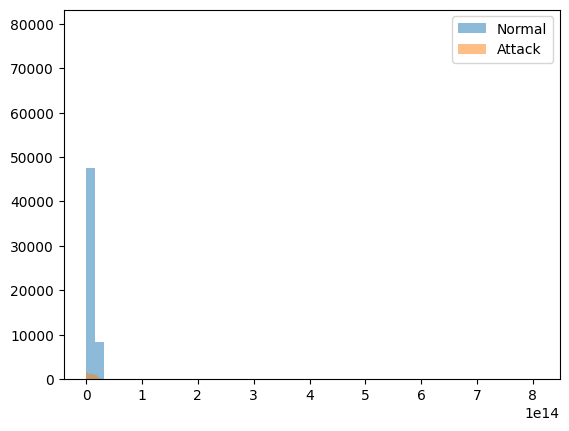

In [6]:
import matplotlib.pyplot as plt

plt.hist(anomaly_scores[df['label']==0], bins=50, alpha=0.5, label='Normal')
plt.hist(anomaly_scores[df['label']==1], bins=50, alpha=0.5, label='Attack')
plt.legend()
plt.show()
